In [1]:
import json
import gzip
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline
import sys
import math
from io import StringIO
import parser
import matplotlib
from imp import reload
sys.path.append('/home/work/zhangzhenhu/Confucius_Server/bin/rpc')
# sys.path.append('/home/work/zhangzhenhu/Confucius_Server/bin/rpc')
from recommend_client import *
from recommend_lib import UIrt2PL
from imp import reload
import datetime
import pyecharts
pyecharts.online(host='https://cdnjs.cloudflare.com/ajax/libs/echarts/4.1.0/')
from IPython.display import display, HTML
# import ai_plot as apt

In [2]:
#from run import main as run
!git stash
!git pull
import feature 
import evaluation
import model as md
reload(feature)
reload(evaluation)
reload(md)


没有要保存的本地修改
Already up-to-date.


<module 'model' from '/home/work/zhangzhenhu/prophet/model/__init__.py'>

# TODO


# 结论

## 指标名词解释


- **accuracy** ：准确率，预测作答结果和实际作答结果一致的数量 占 全部预测样本的 比例。【核心效果指标】

- **mse** ： 所有预测样本中，预测概率 和 真实结果差值的平方和，再开平方。 【次级效果指标】

- **auc_score** ： 取值范围0~1， 越接近1 模型效果越好，至少要0.5以上才行。 【核心模型指标】

- **coverage** ：覆盖率。 能够产出预测结果的样本数量 占 全部需要预测的样本的 比例。【重点效果指标】描述模型能覆盖多少样本

- **uae**:  预测结果算出正确率，和实际正确率的差值。【X】这个指标没有关注个体样本预测是否准确，只是宏观上的学生作答正确率，和我们的场景不匹配。

- **precision_1** ： 正样本精确率。 预测为作对的样本中，有多少比例实际也是作对。

- **precision_0** : 负样本精确率。 预测为作错的样本中，有多少比例实际也是作错。

- **mae** :   所有预测样本中，预测概率 和 真实结果差值 的绝对值 求和。

- **f1_score** ： 


- **题目关联关系说明：**

    题目之间的关联关系，定义了如下两种关系。
    - **包含关系** : 在考察内容上，题目A是题目B的超集，题目A难于题目B。  如果A做对，B也能做对，条件概率P(B|A)；如果B做错，A也会错,条件概率P(~A|~B)
    - **相似关系** : 在考察内容上没有相关性。 如果A做对，B也做对；如果A做错，B也做错。 二者基本是同时做对（做错）

## 本周工作及结果

本周主要进行以下几项工作：
1. 进行了模型的调参工作。
2. 新增了svc模型。
3. 新增了数据预处理步骤：数据集正负样本比例调整、数据归一化、pca降维。

结论
1. 最好的为RandomForest，在73.99%的准确率，覆盖率100%；接下来是GBDT、xgboost，73.8%左右，覆盖率100%。
2. svc的准确率在73.27%, 覆盖率100%。
3. 样本比例调整对模型有反效果。
4. svc在应用pca时效果明显，LR上有反效果。



## 模型迭代对比

相对于上周的模型，本周的模型迭代，主要有以下几方面的变化。

1. 模型LR\GBDT\XGBOOST\RandomForest\DecisionTree等在训练集以及测试集上的准确率均有提升，测试集下，最好准确率在73.99%，覆盖率100%。
2. 新增svc的准确率在73.27%, 覆盖率100%。


## 存在问题

主要是数据问题

# 特征信息

In [3]:
ft = feature.Feature()
ft.fit()

原始训练集大小： 10955
筛选训练集大小： 3428
原始测试集大小： 5462
筛选测试集大小： 1694


In [4]:
import random
rate = ft.label_test.mean()
ratio = (1-rate)/rate
se_1 = [item for item in ft.label_test.index if ft.label_test[item] == 1]
len_del = len(se_1) * (1-ratio)
random.shuffle(se_1)
se_1_sub = se_1[:int(len_del)]
for i,j in zip(ft.features_test.index, ft.label_test.index):
    if j in se_1_sub:
        ft.label_test = ft.label_test.drop(j)
        ft.features_test = ft.features_test.drop(i)
print(ft.label_test.mean())

0.5006353240152478


## 数据集划分

In [5]:
display(ft.describe())

,数量总量,正样本数,正样本比例,负样本数
name,,,,
测试数据,787,394,0.500635,393
训练数据,3428,2377,0.693407,1051
画像数据,48543,31641,0.651814,16902


## 特征列表

In [6]:
display(pd.DataFrame(ft.feature_names))

,0
if_acc,题目画像-正确率
if_answer_count,题目画像-作答次数
if_correct_count,题目画像-正确次数
if_difficulty,题目画像-人工难度
kf_acc,知识点画像-正确率
kf_answer_count,知识点画像-作答次数
kf_correct_count,知识点画像-正确次数
sf_acc,序列特征-正确率
sf_answer_K,序列特征-第k题作答结果
sf_difficulty_k,序列特征-第k题难度


## 训练集特征分布

In [7]:
# # 提出训练集中用户画像答题数少于5题以及题目画像答题数少于20题的数据
# display(ft.features_train.shape[0])
# # display(ft.features_train[['if_answer_count', 'uf_count_all']].head(100))
# features_train_del = ft.features_train.loc[(ft.features_train.if_answer_count>20) & (ft.features_train.uf_count_all>5)]
# display(features_train_del.shape[0])
# # display(features_train_del[['if_answer_count', 'uf_count_all']].head(100))
# display(ft.features_test.shape[0])
# # display(ft.features_train[['if_answer_count', 'uf_count_all']].head(100))
# features_test_del = ft.features_test.loc[(ft.features_test.if_answer_count>20) & (ft.features_test.uf_count_all>5)]
# display(features_test_del.shape[0])
# # display(features_train_del[['if_answer_count', 'uf_count_all']].head(100))

In [8]:
train_info=ft.features_train.describe().transpose()
feature_name = ft.features_train.filter(regex='^uf_|if_|sf_|kf_', axis=1).columns.tolist()
fea_ = []
pro_ = []
def na_pro(data):
    for fea in feature_name:
        fea_.append(fea)
        if 'sf_answer_' in fea or 'sf_difficulty_' in fea:
            pro = data.loc[data[fea] == 0].shape[0] / data.shape[0]
        else:
            pro = data[fea].isnull().sum() / data.shape[0]
        pro_.append(pro)
na_pro(ft.features_train)
dict_na = {'feature':fea_,
           '空值比例':pro_
          }
dict_na = pd.DataFrame(dict_na).set_index('feature')
# print(dict_na)
train_info = train_info.join(dict_na, how='inner')
display(train_info)
train_info['空值比例'].describe()

,count,mean,std,min,25%,50%,75%,max,空值比例
feature,,,,,,,,,
uf_accuracy_1,3418.0,0.625392,0.177057,0.000000,0.494382,0.611111,0.777778,1.000000,0.002917
uf_accuracy_2,2273.0,0.588769,0.253916,0.000000,0.500000,0.636364,0.750000,1.000000,0.336931
uf_accuracy_3,1646.0,0.270472,0.316795,0.000000,0.000000,0.000000,0.555556,1.000000,0.519837
uf_accuracy_4,318.0,0.477314,0.354211,0.000000,0.000000,0.500000,0.750000,1.000000,0.907235
uf_accuracy_all,3428.0,0.609581,0.146107,0.066667,0.500000,0.611111,0.719577,0.933333,0.000000
uf_count_1,3418.0,51.145407,48.299308,1.000000,15.000000,33.000000,70.000000,271.000000,0.002917
uf_count_2,2273.0,15.301804,20.740081,1.000000,4.000000,9.000000,18.000000,121.000000,0.336931
uf_count_3,1646.0,4.979344,5.466744,1.000000,1.000000,3.000000,7.000000,22.000000,0.519837
uf_count_4,318.0,2.440252,1.866494,1.000000,1.000000,2.000000,3.750000,7.000000,0.907235


count    48.000000
mean      0.204140
std       0.277633
min       0.000000
25%       0.000000
50%       0.046820
75%       0.347360
max       0.907235
Name: 空值比例, dtype: float64

## 测试集特征分布

In [9]:
test_info=ft.features_test.describe().transpose()
fea_ = []
pro_ = []
def na_pro(data):
    for fea in feature_name:
        fea_.append(fea)
        if 'sf_answer_' in fea or 'sf_difficulty_' in fea:
            pro = data.loc[data[fea] == 0].shape[0] / data.shape[0]
        else:
            pro = data[fea].isnull().sum() / data.shape[0]
        pro_.append(pro)
na_pro(ft.features_test)
dict_na = {'feature':fea_,
           '空值比例':pro_
          }
dict_na = pd.DataFrame(dict_na).set_index('feature')
# print(dict_na)
test_info = test_info.join(dict_na, how='inner')
test_info

,count,mean,std,min,25%,50%,75%,max,空值比例
feature,,,,,,,,,
uf_accuracy_1,727.0,0.709632,0.195189,0.000000,0.583333,0.750000,0.833333,1.000000,0.076239
uf_accuracy_2,621.0,0.708250,0.273637,0.000000,0.611111,0.761905,0.888889,1.000000,0.210928
uf_accuracy_3,548.0,0.273360,0.287368,0.000000,0.000000,0.250000,0.500000,1.000000,0.303685
uf_accuracy_4,109.0,0.045872,0.210173,0.000000,0.000000,0.000000,0.000000,1.000000,0.861499
uf_accuracy_all,787.0,0.681887,0.151934,0.066667,0.594203,0.699115,0.786667,0.933333,0.000000
uf_count_1,727.0,41.547455,34.906094,2.000000,12.000000,41.000000,56.000000,159.000000,0.076239
uf_count_2,621.0,12.214171,12.125454,1.000000,3.000000,9.000000,17.000000,54.000000,0.210928
uf_count_3,548.0,3.609489,3.840140,1.000000,1.000000,2.000000,4.000000,17.000000,0.303685
uf_count_4,109.0,1.238532,0.428155,1.000000,1.000000,1.000000,1.000000,2.000000,0.861499


# 模型训练

## 训练

In [10]:
feature_name = ft.features_test.filter(regex='^uf_|if_|sf_|kf_', axis=1).columns.tolist()
feature_list = list(set(feature_name)^set(['uf_theta', 'sf_theta', 'sf_irt_prob']))
# print(feature_list)
ft.fillna()
models = [
#     md.POKS_SIM(ft).fit(), 
#     md.POKS(ft).fit(), 
#     md.CF(feature=ft,kind='user_base').fit(),
#     md.CF(feature=ft,kind='item_base').fit(),
    md.Irt(ft).fit(),
    md.LR(ft).fit(),
    md.AdaBoost(ft).fit(),
    md.DecisionTree(ft).fit(),
    md.GradientBoostingTree(ft).fit(),
    md.RandomForest(ft).fit(),
    md.Xgboost(ft).fit(),
    md.SVC_Model(ft, kernel='rbf').fit(k_single=0, k_pca=0.9),
    md.LR(ft).fit(feature_list=feature_list),
    md.AdaBoost(ft).fit(feature_list=feature_list),
    md.DecisionTree(ft).fit(feature_list=feature_list),
    md.GradientBoostingTree(ft).fit(feature_list=feature_list),
    md.RandomForest(ft).fit(feature_list=feature_list),
    md.Xgboost(ft).fit(feature_list=feature_list),
    md.SVC_Model(ft, kernel='rbf').fit(k_single=0, k_pca=0.9, feature_list=feature_list),
]

for i, model in enumerate(models):
    if i > 7:
        model.test(feature_list=feature_list)
    else:
        model.test()
   

In [11]:
# for i, model in enumerate(models):
#     print(model)
#     print(len(model.train_x.columns))

## 训练集效果

### 指标

In [12]:
ev = evaluation.EvaluationMany(models)
display(ev.evaluate(target="train"))

,accuracy,coverage,tpr,fpr,precision_1,precision_0,uae,mae,mse,auc_score,f1_score,description
name,,,,,,,,,,,,
AdaBoost(-irt),0.974621,1.0,0.982331,0.042816,0.981092,0.959924,0.000875,0.418369,0.188261,0.997044,0.981711,AdaBoost
AdaBoost,0.969370,1.0,0.979806,0.054234,0.976111,0.953935,0.002625,0.427046,0.194159,0.996546,0.977955,AdaBoost
xgboost(-irt),0.828763,1.0,0.928061,0.395814,0.841342,0.787841,0.071470,0.269967,0.118318,0.905826,0.882577,单纯的xgboost模型
xgboost,0.827596,1.0,0.928481,0.400571,0.839802,0.787500,0.073221,0.271294,0.119304,0.903786,0.881918,单纯的xgboost模型
GBDT(-irt),0.808635,1.0,0.920909,0.445290,0.823861,0.756161,0.081680,0.292824,0.133098,0.875330,0.869686,GBDT
GBDT,0.806884,1.0,0.919647,0.448145,0.822732,0.752270,0.081680,0.294261,0.133958,0.873079,0.868494,GBDT
SVC,0.803384,1.0,0.940261,0.506185,0.807734,0.785174,0.113769,0.196616,0.196616,0.717038,0.868974,rbf支持向量机分类
SVC(-irt),0.803092,1.0,0.938999,0.504282,0.808110,0.782282,0.112310,0.196908,0.196908,0.717359,0.868651,rbf支持向量机分类
random_forest(-irt),0.792882,1.0,0.916281,0.486204,0.809967,0.730717,0.091015,0.308078,0.142249,0.854644,0.859850,随机森林


In [13]:
out={}
name = ["xgboost(-irt)", "AdaBoost(-irt)", "AdaBoost", "GBDT(-irt)"]
accuracy = [0.758168, 0.756126, 0.754312, 0.754019]
cover = [1.0, 1.0, 1.0, 1.0]
tpr = [0.899874, 0.88645, 0.868679, 0.864735]
fpr = [0.562322, 0.568982, 0.570465, 0.576346]
out["name"] = name
out["accuracy"] = accuracy
out["coverage"] = cover
out["tpr"] = tpr
out["fpr"] = fpr
a=pd.DataFrame(out)
a=a.set_index(['name'])
display(a[["accuracy","coverage","tpr","fpr"]])

,accuracy,coverage,tpr,fpr
name,,,,
xgboost(-irt),0.758168,1.0,0.899874,0.562322
AdaBoost(-irt),0.756126,1.0,0.886450,0.568982
AdaBoost,0.754312,1.0,0.868679,0.570465
GBDT(-irt),0.754019,1.0,0.864735,0.576346


###  roc曲线

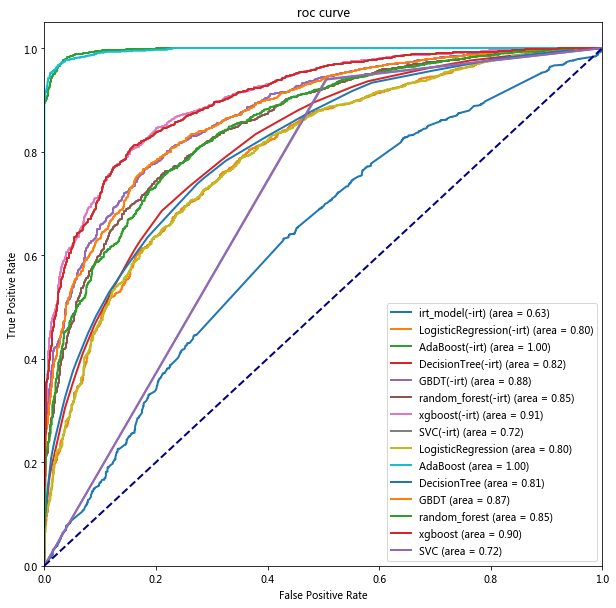

In [13]:
ev.plot_allin(target="train")

# 模型评估

## 测试数据数量

In [14]:
display(ft.describe())

,数量总量,正样本数,正样本比例,负样本数
name,,,,
测试数据,787,394,0.500635,393
训练数据,3428,2377,0.693407,1051
画像数据,48543,31641,0.651814,16902


## 整体效果指标

In [15]:
ev = evaluation.EvaluationMany(models)
df_ev=ev.evaluate()
display(df_ev)

,accuracy,coverage,tpr,fpr,precision_1,precision_0,uae,mae,mse,auc_score,f1_score,description
name,,,,,,,,,,,,
AdaBoost,0.601017,1.0,0.842640,0.641221,0.568493,0.694581,0.241423,0.460181,0.231605,0.684026,0.678937,AdaBoost
irt_model(-irt),0.583227,1.0,0.878173,0.712468,0.552716,0.701863,0.294790,0.444546,0.294359,0.621098,0.678431,irt_model
AdaBoost(-irt),0.573062,1.0,0.895939,0.750636,0.544753,0.705036,0.322745,0.463668,0.237159,0.685389,0.677543,AdaBoost
xgboost,0.550191,1.0,0.934010,0.834606,0.528736,0.714286,0.383736,0.432234,0.280853,0.733309,0.675229,单纯的xgboost模型
LogisticRegression(-irt),0.548920,1.0,0.928934,0.832061,0.528139,0.702128,0.379924,0.433819,0.272926,0.732366,0.673413,逻辑回归
LogisticRegression,0.547649,1.0,0.926396,0.832061,0.527457,0.694737,0.378653,0.435637,0.275005,0.725604,0.672192,逻辑回归
GBDT(-irt),0.546379,1.0,0.956853,0.865140,0.525802,0.757143,0.410419,0.439541,0.281768,0.734426,0.678668,GBDT
GBDT,0.546379,1.0,0.946701,0.854962,0.526093,0.730769,0.400254,0.439937,0.281479,0.726205,0.676337,GBDT
xgboost(-irt),0.545108,1.0,0.926396,0.837150,0.525937,0.688172,0.381194,0.431819,0.283613,0.737791,0.670956,单纯的xgboost模型


In [16]:
bar=pyecharts.Bar()
for mn,row in df_ev.iterrows():
    df_one=row.loc[['accuracy','precision_1','precision_0','mae','mse','auc_score','f1_score']]
    bar.add(mn,df_one.index.tolist(),df_one.astype('float').round(4))
    # print(df_one.index)
display(bar)

## 各题号效果指标

In [17]:
df_ev_no=ev.evaluate_no().sort_values(['题号','accuracy'])

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
bar=pyecharts.Bar()
for mn in df_ev_no.index.unique():
    df_one=df_ev_no.loc[mn].sort_values('题号')
    bar.add(mn,df_one['题号'],df_one['accuracy'].round(4))
display(bar)

## roc 曲线

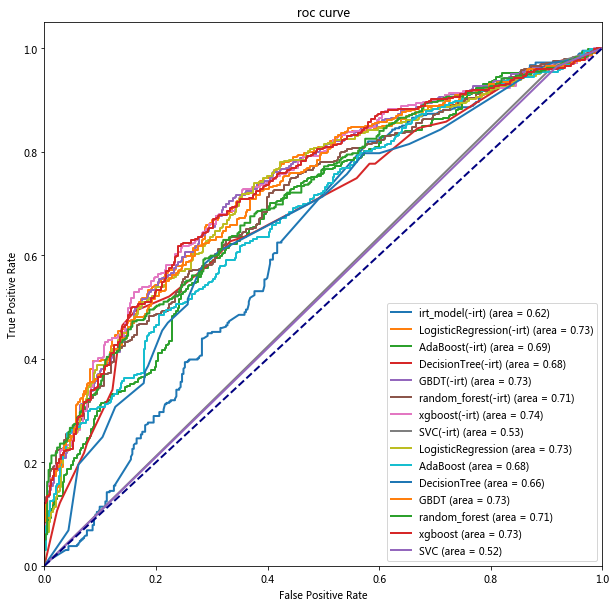

In [19]:
ev.plot_allin(target="test")

# badcase analysis

## 模型覆盖率

In [20]:
display(ev.evaluate(target="train")['coverage'])

name
AdaBoost(-irt)              1.0
AdaBoost                    1.0
xgboost(-irt)               1.0
xgboost                     1.0
GBDT(-irt)                  1.0
GBDT                        1.0
SVC                         1.0
SVC(-irt)                   1.0
random_forest(-irt)         1.0
random_forest               1.0
DecisionTree(-irt)          1.0
DecisionTree                1.0
LogisticRegression(-irt)    1.0
LogisticRegression          1.0
irt_model(-irt)             1.0
Name: coverage, dtype: float64

### 结论
从上面模型覆盖率看出 poks 与 cf 的覆盖率极低，反映出答题矩阵的稀疏性很高，并不能挖掘出大量的关系、并不能有效计算学生以及题目的相似性。

## 样本属性空值分析

### 训练集

In [21]:
display(train_info)
train_info['空值比例'].describe()

,count,mean,std,min,25%,50%,75%,max,空值比例
feature,,,,,,,,,
uf_accuracy_1,3418.0,0.625392,0.177057,0.000000,0.494382,0.611111,0.777778,1.000000,0.002917
uf_accuracy_2,2273.0,0.588769,0.253916,0.000000,0.500000,0.636364,0.750000,1.000000,0.336931
uf_accuracy_3,1646.0,0.270472,0.316795,0.000000,0.000000,0.000000,0.555556,1.000000,0.519837
uf_accuracy_4,318.0,0.477314,0.354211,0.000000,0.000000,0.500000,0.750000,1.000000,0.907235
uf_accuracy_all,3428.0,0.609581,0.146107,0.066667,0.500000,0.611111,0.719577,0.933333,0.000000
uf_count_1,3418.0,51.145407,48.299308,1.000000,15.000000,33.000000,70.000000,271.000000,0.002917
uf_count_2,2273.0,15.301804,20.740081,1.000000,4.000000,9.000000,18.000000,121.000000,0.336931
uf_count_3,1646.0,4.979344,5.466744,1.000000,1.000000,3.000000,7.000000,22.000000,0.519837
uf_count_4,318.0,2.440252,1.866494,1.000000,1.000000,2.000000,3.750000,7.000000,0.907235


count    48.000000
mean      0.204140
std       0.277633
min       0.000000
25%       0.000000
50%       0.046820
75%       0.347360
max       0.907235
Name: 空值比例, dtype: float64

### 训练集

In [22]:
display(test_info)
test_info['空值比例'].describe()

,count,mean,std,min,25%,50%,75%,max,空值比例
feature,,,,,,,,,
uf_accuracy_1,727.0,0.709632,0.195189,0.000000,0.583333,0.750000,0.833333,1.000000,0.076239
uf_accuracy_2,621.0,0.708250,0.273637,0.000000,0.611111,0.761905,0.888889,1.000000,0.210928
uf_accuracy_3,548.0,0.273360,0.287368,0.000000,0.000000,0.250000,0.500000,1.000000,0.303685
uf_accuracy_4,109.0,0.045872,0.210173,0.000000,0.000000,0.000000,0.000000,1.000000,0.861499
uf_accuracy_all,787.0,0.681887,0.151934,0.066667,0.594203,0.699115,0.786667,0.933333,0.000000
uf_count_1,727.0,41.547455,34.906094,2.000000,12.000000,41.000000,56.000000,159.000000,0.076239
uf_count_2,621.0,12.214171,12.125454,1.000000,3.000000,9.000000,17.000000,54.000000,0.210928
uf_count_3,548.0,3.609489,3.840140,1.000000,1.000000,2.000000,4.000000,17.000000,0.303685
uf_count_4,109.0,1.238532,0.428155,1.000000,1.000000,1.000000,1.000000,2.000000,0.861499


count    48.000000
mean      0.179797
std       0.255309
min       0.000000
25%       0.000000
50%       0.058450
75%       0.293202
max       0.861499
Name: 空值比例, dtype: float64

### 结论

数据的大部分属性空值比例较高，均值达到24%左右。

## 样本分类结果集中情况

In [23]:
from sklearn.externals.six import StringIO
import pydotplus
from sklearn import tree
import graphviz
from evaluation import EvaluationMany
import matplotlib.pyplot as plt
import re
import pyecharts

"""
part 1
the sample predicted by all the models
"""

def all_t_f(data):
    error = 0
    for item in data:
        if item != int(data['sample_label']):
            error += 1
    return error


models_copy = models[1:7]
pattern = re.compile(r'model\.(.*?) ')
dict_sp = {}
dict_sp['sample_label'] = ft.label_test.values
for i, single in enumerate(models_copy):
    print(single)
    model_name = pattern.findall(str(single))[0]
    dict_sp[model_name] = single.test_y_pred
sample_pred = pd.DataFrame(dict_sp)
# sample_pred_int = (sample_pred+0.5).astype(int)
int_ = lambda x: 1 if x>=0.5 else 0
sample_pred_int = sample_pred.applymap(int_)
# # calculate the coefficient
# coe = sample_pred.corr()
# # display(coe)

# # calculate the cos
# pred_model = sample_pred_int.values
# epsilon = 1e-9
# sim = pred_model.T.dot(pred_model) + epsilon
# norms = np.array([np.sqrt(np.diagonal(sim))])
# cos = sim / norms / norms.T
# cos = pd.DataFrame(cos, index=coe.index, columns=coe.columns)
# # display(cos)

# calculate the rate of wrong predicted model

sample_pred_int['rate'] = sample_pred_int.apply(all_t_f, axis=1)
writer = pd.ExcelWriter('./样本分类结果.xlsx')
sample_pred_int.to_excel(writer)

features_test = ft.features_test.copy()
features_test['wp_num'] = sample_pred_int['rate']
features_test['真实标签'] = sample_pred_int['sample_label']
features_test['预测标签'] = sample_pred_int['lr_model.LR']
features_test['lr_prob'] = sample_pred['lr_model.LR']
features_test['gbdt_prob'] = sample_pred['tree.GradientBoostingTree']

features_train = ft.features_train.copy()
features_train['预测'] = [1 if item >=0.5 else 0 for item in models_copy[3].train_y_pred.tolist()]
features_train['真实'] =ft.label_train.values
# display(features_train)
features_train_unique = features_train.loc[(features_train.if_acc_new > 0.6) & (features_train.sf_irt_prob > 0.7) & (features_train.真实 == 0)]
print(features_train_unique.shape[0])
features_test_unique = features_test.loc[(features_test.if_acc_new > 0.6) & (features_test.sf_irt_prob > 0.7) & (features_test.真实标签 == 0)]
print(features_test_unique.shape[0])
features_test_wa = features_test[features_test['wp_num']==6]
# display(features_test_wa.loc[features_test_wa.真实标签==features_test_wa.预测标签])
display(features_test_wa[['wp_num', '真实标签', '预测标签', 'gbdt_prob', 'if_acc_new', 'sf_theta', 'if_difficulty', 'sf_irt_prob']])
features_test_sample = features_test_wa.sample(frac=1)
writer = pd.ExcelWriter('./全分错样本抽样.xlsx')
features_test_sample.to_excel(writer)

# 473752b0179e49999a82aefbbf3a618e	6c6d91efe6de40e9ba0202436d151437	

# 分类错误学生统计
user_wf = features_test_wa.user_id.value_counts(ascending=False)
user_wfa = features_test.user_id.value_counts()
user_wf=pd.DataFrame(user_wf)
user_wfa=pd.DataFrame(user_wfa)
user_wf_rate = user_wf.join(user_wfa, lsuffix='_caller', rsuffix='_other', how='left')
user_wf_rate = user_wf_rate.rename(columns={"user_id_caller": "全部分类错误数量", "user_id_other": "答题数量"})
user_wf_rate['rate'] = user_wf_rate['全部分类错误数量']/user_wf_rate['答题数量']
display(user_wf_rate.head(10))
writer = pd.ExcelWriter('./全部分类错误-答题数量.xlsx')
user_wf_rate.to_excel(writer)

rate_group = sample_pred_int.groupby('rate').agg({'tree.Xgboost': 'count'}).rename(columns={'tree.Xgboost':'count'})
bar = pyecharts.Bar("分类器分类错误数量")
bar.add("", rate_group.index.tolist(), list(rate_group['count']),is_stack=True,is_more_utils=True, is_label_show=True)
display(bar)

bar = pyecharts.Bar("分类器分类错误数量占比")
bar.add("", rate_group.index.tolist(), (rate_group['count']/rate_group['count'].sum()).round(4),is_stack=True,is_more_utils=True, is_label_show=True)
display(bar)

216
16


,wp_num,真实标签,预测标签,gbdt_prob,if_acc_new,sf_theta,if_difficulty,sf_irt_prob
56,6.0,0.0,1.0,0.852523,0.489209,3.358386,1.0,0.982259
67,6.0,0.0,1.0,0.882016,0.980100,2.835852,1.0,0.957897
71,6.0,0.0,1.0,0.751581,0.291667,3.162324,1.0,0.975404
73,6.0,0.0,1.0,0.671876,0.151111,2.862431,1.0,0.959684
82,6.0,0.0,1.0,0.676957,0.934911,2.554640,1.0,0.933764
93,6.0,0.0,1.0,0.926143,0.452381,2.500000,1.0,0.927775
99,6.0,0.0,1.0,0.774640,0.111111,2.856145,3.0,0.439094
107,6.0,0.0,1.0,0.869715,0.504274,1.500000,1.0,0.700777
108,6.0,0.0,1.0,0.848142,0.975610,1.645486,1.0,0.750001
109,6.0,0.0,1.0,0.939256,0.571429,1.814511,1.0,0.800001


,全部分类错误数量,答题数量,rate
473752b0179e49999a82aefbbf3a618e,13,45,0.288889
9618023f15014a24ba7b21d8444924a6,9,57,0.157895
bf345f89bd674049a0da716ed9278324,7,9,0.777778
a35e8512d3eb49a5ac1d66ca7e9d87eb,2,26,0.076923
143cde8288f54a6dbb3256be1707dfe6,2,9,0.222222
cac98de1fbf6429c8ae9576d6e6f5f71,2,6,0.333333
96a27544f53d4800b9c72edde9da4bfa,1,7,0.142857


### 结论
1. 从上面学生维度的分类器结果，可知，分类器全部预测错的样本所占该学生的全部答题量的比例大致相同，并不集中在某些学生。
2. 从分类器分类错误数量图像可看出，呈下凸形状，50%的样本所有分类器全部分对，80%的样本的分类器分错数量少于4。
   在图像右侧，曲线呈上升趋势，说明易分错的样本在所有分类器上都容易分错，有两个原因：a.其中的六个分类器是基于树模型的；b.这些样本可能难以分类。4、5、6、7占比达到27%，说明这几个分类器并不太适合做bagging。


## 特征重要性分析

### 保留irt特征

In [24]:
"""
part 2
feature importance analysis
"""
feature_num_all = []
feature_val_all = []
tree_features = []
lr_features = []
for i, model in enumerate(models_copy):
    feature_importance = {}
    model_name = pattern.findall(str(model))[0]
#     print(model_name)
    if 'lr' in model_name:
        for j in range(len(feature_name)):
            feature_importance[feature_name[j]] = model.model.coef_[0][j]
        feature_import_sort = sorted(feature_importance.items(), key=lambda item: abs(item[1]), reverse=True)
        # print(feature_import_sort)
        feature_import_num = [(model_name, item[0], i+1) for i, item in enumerate(feature_import_sort)]
        feature_import_val = [(model_name, item[0], item[1]) for i, item in enumerate(feature_import_sort)]
        # print(feature_import_num)
        feature_num_all.extend(feature_import_num)
        feature_val_all.extend(feature_import_val)
        lr_features = feature_import_num
    elif 'SVC_Model' in model_name:
        # importance only available in linear kernel
        continue
        for j in range(len(feature_name)):
            feature_importance[feature_name[j]] = model.model.coef_[0][j]
        feature_import_sort = sorted(feature_importance.items(), key=lambda item: abs(item[1]), reverse=True)
        feature_import_val = [(model_name, item[0], item[1]) for i, item in enumerate(feature_import_sort)]
        # print(feature_import_sort)
        feature_import_num = [(model_name, item[0], i+1) for i, item in enumerate(feature_import_sort)]
        # print(feature_import_num)
        feature_num_all.extend(feature_import_num)
        feature_val_all.extend(feature_import_val)
    else:
        try:
            for j in range(len(feature_name)):
                feature_importance[feature_name[j]] = model.model.feature_importances_[j]
            feature_import_sort = sorted(feature_importance.items(), key=lambda item: abs(item[1]), reverse=True)
            # print(feature_import_sort)
            feature_import_num = [(model_name, item[0], i+1) for i, item in enumerate(feature_import_sort)]
            feature_import_val = [(model_name, item[0], item[1]) for i, item in enumerate(feature_import_sort)]
            # print(feature_import_num)
            feature_num_all.extend(feature_import_num)
            feature_val_all.extend(feature_import_val)
            if 'Gra' in model_name:
                tree_features = feature_import_num
        except:
            pass

In [25]:
tree_feature = [item[1] for item in tree_features]
lr_feature = [item[1] for item in lr_features]

top_10_lr = lr_feature[:10]
top_10_tree = tree_feature[:10]
model_feature_num = pd.DataFrame(feature_num_all)
model_feature_num
model_feature_num = model_feature_num.pivot_table(2, 0, 1)
# display(HTML("<h4>lr top 10 feature</h4>"))
lr = pd.DataFrame(model_feature_num.loc['lr_model.LR', top_10_lr])
lr_num = lr.join(train_info[['空值比例']])
# display(lr_num)
# display(HTML("<h4>gdbt top 10 feature</h4>"))
gbdt = pd.DataFrame(model_feature_num.loc['tree.GradientBoostingTree', top_10_tree])
gbdt_num = gbdt.join(train_info[['空值比例']])
# display(gbdt_num)

model_feature_val = pd.DataFrame(feature_val_all)
model_feature_val = model_feature_val.pivot_table(2, 0, 1)
# display(HTML("<h4>lr top 10 feature</h4>"))
lr = pd.DataFrame(model_feature_val.loc['lr_model.LR', top_10_lr])
lr_val = lr.join(train_info[['空值比例']])
# display(lr_val)
# display(HTML("<h4>gdbt top 10 feature</h4>"))
gbdt = pd.DataFrame(model_feature_val.loc['tree.GradientBoostingTree', top_10_tree])
gbdt_val = gbdt.join(train_info[['空值比例']])
# display(gbdt_val)

display(HTML("<h4>lr top 10 feature</h4>"))
lr_num_val = lr_num.join(lr_val[['lr_model.LR']], lsuffix='_排序', rsuffix='_数值')
lr_num_val = lr_num_val[['lr_model.LR_排序', 'lr_model.LR_数值', '空值比例']]
display(lr_num_val)


display(HTML("<h4>gbdt top 10 feature</h4>"))
gbdt_num_val = gbdt_num.join(gbdt_val[['tree.GradientBoostingTree']], lsuffix='_排序', rsuffix='_数值')
gbdt_num_val = gbdt_num_val[['tree.GradientBoostingTree_排序', 'tree.GradientBoostingTree_数值', '空值比例']]
display(gbdt_num_val)

# calculate the coefficient of the model and the features
# the features' coefficient
coe = model_feature_num.corr(method='spearman')
# display(coe)
# the models' coefficient
coe = model_feature_num.T.corr(method='spearman')
# display(coe)


,lr_model.LR_排序,lr_model.LR_数值,空值比例
1,,,
sf_difficulty_2,1,0.899246,0.007293
sf_difficulty_3,2,0.272628,0.015461
uf_count_1,3,-0.227668,0.002917
uf_count_3,4,-0.218806,0.519837
uf_right_1,5,0.188153,0.002917
sf_answer_2,6,0.143705,0.161027
sf_acc,7,0.127209,0.000000
if_answer_count,8,0.107055,0.000000
sf_difficulty_1,9,-0.103157,0.000000


,tree.GradientBoostingTree_排序,tree.GradientBoostingTree_数值,空值比例
1,,,
if_acc_new,1,0.236760,0.000000
sf_theta,2,0.062413,0.000000
if_correct_count,3,0.061596,0.000000
uf_accuracy_1,4,0.042089,0.002917
sf_irt_prob,5,0.039564,0.000000
if_answer_count,6,0.038985,0.000000
uf_accuracy_all,7,0.037006,0.000000
uf_theta,8,0.033995,0.000000
kf_acc_new,9,0.032174,0.000000


#### 结论
模型的重要特征质量不高（空值比例较高且重要性值偏低），表现在以下几方面：
1. gbdt的top3重要特征是if_acc、if_combine、sf_irt_prob，但是top2的属性的空值比例较多。
2. lr的top3重要特征是uf_count_1、if_answer_count、uf_count_2，但是top3的属性的空值比例较多。
3. gbdt的特征重要性数值偏低

In [26]:
# display(features_test_sample.head())
writer = pd.ExcelWriter('./样本特征与特征值表格.xlsx')
fea_list_lr = []
fea_list_tr = []
fea_list_lr_ = []
fea_list_tr_ = []
out_columns_lr = ['user_id', 'item_id', 'knowledge_id', '真实标签', '预测标签', 'lr_prob']
out_columns_lr.extend(lr_feature)
out_columns_tr = ['user_id', 'item_id', 'knowledge_id', '真实标签', '预测标签', 'gbdt_prob']
out_columns_tr.extend(tree_feature)
lr_output = features_test_sample[out_columns_lr]
tr_output = features_test_sample[out_columns_tr]
# lr
for fea in lr_output.columns:
    if fea in lr_feature:
        fea_list_lr.append(model_feature_val.loc['lr_model.LR', fea])
    else:
        fea_list_lr.append(0)
df_fea = pd.DataFrame(columns=out_columns_lr)
df_fea.loc['lr_fea_val'] = fea_list_lr
df_fea_val = df_fea.append(lr_output)
display(df_fea_val.head())
df_fea_val.to_excel(writer, 'Sheet1')

# tree
for fea in tr_output.columns:
    if fea in tree_feature:
        fea_list_tr.append(model_feature_val.loc['tree.GradientBoostingTree', fea])
    else:
        fea_list_tr.append(0)
df_fea = pd.DataFrame(columns=out_columns_tr)
df_fea.loc['gbdt_fea_val'] = fea_list_tr
df_fea_val = df_fea.append(tr_output)
display(df_fea_val.head())
df_fea_val.to_excel(writer, 'Sheet2')

,user_id,item_id,knowledge_id,真实标签,预测标签,lr_prob,sf_difficulty_2,sf_difficulty_3,uf_count_1,uf_count_3,...,sf_irt_prob,uf_right_all,sf_no,uf_accuracy_4,sf_answer_3,uf_count_all,uf_theta,uf_accuracy_1,kf_answer_count,uf_right_4
lr_fea_val,0,0,0,0.0,0.0,0.000000,0.899246,0.272628,-0.227668,-0.218806,...,0.011714,0.008436,-0.007879,-0.005577,-0.00542,0.003148,-0.002971,-0.002295,0.001021,-0.00008
500,473752b0179e49999a82aefbbf3a618e,6934a1061cdc409185d0728286bfc0df,f8f3f0456e054b6295d375c17593f42e,0.0,1.0,0.899492,2.000000,3.000000,41.000000,0.000000,...,0.840419,28.000000,6.000000,0.000000,-1.00000,41.000000,1.450796,0.682927,5408.000000,0.00000
248,473752b0179e49999a82aefbbf3a618e,4757c204b25e4552a43437ffc699ab68,f5a5e87236af42849871fbf3b37e6ca5,0.0,1.0,0.883401,1.000000,1.000000,41.000000,0.000000,...,0.700777,28.000000,2.000000,0.000000,0.00000,41.000000,1.450796,0.682927,1475.000000,0.00000
627,96a27544f53d4800b9c72edde9da4bfa,cb5bf6276e514d56a0626e515c2f30e7,6oo7ryi0e79zkqai08wbmeohxn6c0477,0.0,1.0,0.866882,1.000000,1.000000,15.000000,2.000000,...,0.700777,12.000000,1.000000,0.000000,0.00000,17.000000,1.762740,0.666667,598.000000,0.00000
501,473752b0179e49999a82aefbbf3a618e,ad0928986d1c4b3299159d455b3a48c5,f8f3f0456e054b6295d375c17593f42e,0.0,1.0,0.711903,2.000000,3.000000,41.000000,0.000000,...,0.862350,28.000000,7.000000,0.000000,-1.00000,41.000000,1.450796,0.682927,5408.000000,0.00000


,user_id,item_id,knowledge_id,真实标签,预测标签,gbdt_prob,if_acc_new,sf_theta,if_correct_count,uf_accuracy_1,...,sf_difficulty_8,sf_difficulty_9,uf_right_3,uf_right_4,sf_answer_2,sf_difficulty_2,uf_accuracy_4,sf_difficulty_3,sf_difficulty_1,uf_count_4
gbdt_fea_val,0,0,0,0.0,0.0,0.000000,0.236760,0.062413,0.061596,0.042089,...,0.003473,0.002937,0.002319,0.00182,0.001738,0.000695,0.000498,0.000383,0.000248,0.000108
500,473752b0179e49999a82aefbbf3a618e,6934a1061cdc409185d0728286bfc0df,f8f3f0456e054b6295d375c17593f42e,0.0,1.0,0.901808,0.887324,1.976115,62.000000,0.682927,...,1.000000,1.000000,0.000000,0.00000,-1.000000,2.000000,0.000000,3.000000,2.000000,0.000000
248,473752b0179e49999a82aefbbf3a618e,4757c204b25e4552a43437ffc699ab68,f5a5e87236af42849871fbf3b37e6ca5,0.0,1.0,0.927739,0.743902,1.500000,60.000000,0.682927,...,2.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
627,96a27544f53d4800b9c72edde9da4bfa,cb5bf6276e514d56a0626e515c2f30e7,6oo7ryi0e79zkqai08wbmeohxn6c0477,0.0,1.0,0.839821,0.677419,1.500000,20.000000,0.666667,...,1.000000,1.000000,2.000000,0.00000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
501,473752b0179e49999a82aefbbf3a618e,ad0928986d1c4b3299159d455b3a48c5,f8f3f0456e054b6295d375c17593f42e,0.0,1.0,0.635321,0.888889,2.078112,47.000000,0.682927,...,1.000000,1.000000,0.000000,0.00000,-1.000000,2.000000,0.000000,3.000000,2.000000,0.000000


### 删除irt特征

In [27]:
# """
# part 2
# feature importance analysis
# """
# models_copy = models[8:]
# feature_num_all = []
# feature_val_all = []
# tree_features = []
# lr_features = []
# for i, model in enumerate(models_copy):
#     feature_importance = {}
#     model_name = pattern.findall(str(model))[0]
#     print(model_name)
#     if 'lr' in model_name:
#         for j in range(len(feature_list)):
#             feature_importance[feature_list[j]] = model.model.coef_[0][j]
#         feature_import_sort = sorted(feature_importance.items(), key=lambda item: abs(item[1]), reverse=True)
#         # print(feature_import_sort)
#         feature_import_num = [(model_name, item[0], i+1) for i, item in enumerate(feature_import_sort)]
#         feature_import_val = [(model_name, item[0], item[1]) for i, item in enumerate(feature_import_sort)]
#         # print(feature_import_num)
#         feature_num_all.extend(feature_import_num)
#         feature_val_all.extend(feature_import_val)
#         lr_features = feature_import_num
#     elif 'SVC_Model' in model_name:
#         # importance only available in linear kernel
#         continue
#         for j in range(len(feature_list)):
#             feature_importance[feature_list[j]] = model.model.coef_[0][j]
#         feature_import_sort = sorted(feature_importance.items(), key=lambda item: abs(item[1]), reverse=True)
#         feature_import_val = [(model_name, item[0], item[1]) for i, item in enumerate(feature_import_sort)]
#         # print(feature_import_sort)
#         feature_import_num = [(model_name, item[0], i+1) for i, item in enumerate(feature_import_sort)]
#         # print(feature_import_num)
#         feature_num_all.extend(feature_import_num)
#         feature_val_all.extend(feature_import_val)
#     else:
#         try:
#             for j in range(len(feature_list)):
#                 feature_importance[feature_list[j]] = model.model.feature_importances_[j]
#             feature_import_sort = sorted(feature_importance.items(), key=lambda item: abs(item[1]), reverse=True)
#             # print(feature_import_sort)
#             feature_import_num = [(model_name, item[0], i+1) for i, item in enumerate(feature_import_sort)]
#             feature_import_val = [(model_name, item[0], item[1]) for i, item in enumerate(feature_import_sort)]
#             # print(feature_import_num)
#             feature_num_all.extend(feature_import_num)
#             feature_val_all.extend(feature_import_val)
#             if 'Ada' in model_name:
#                 tree_features = feature_import_num
#         except:
#             pass

# tree_feature = [item[1] for item in tree_features]
# top_10 = tree_feature[:10]
# print(top_10)
# model_featurn_num = pd.DataFrame(feature_num_all)
# model_featurn_num = model_featurn_num.pivot_table(2, 0, 1)
# display(model_featurn_num[top_10])

# model_featurn_val = pd.DataFrame(feature_val_all)
# model_featurn_val = model_featurn_val.pivot_table(2, 0, 1)
# display(model_featurn_val[top_10])

# # calculate the coefficient of the model and the features
# # the features' coefficient
# coe = model_featurn_num.corr(method='spearman')
# # display(coe)
# # the models' coefficient
# coe = model_featurn_num.T.corr(method='spearman')

## top3属性样本区分能力情况

In [28]:
# analysis the wp of lr and tree
# tree--xgboost--overfit
# train
# 0.771702
print(models_copy[3])
tree_feature = [item[1] for item in tree_features]
top_10 = tree_feature[:10]
train_tree = models_copy[3].train_x.copy()
train_tree['label'] = models_copy[3].train_y
tree_pred = (models_copy[3].train_y_pred+0.5).astype(int)
train_tree['pred'] = tree_pred
top_10.extend(['label', 'pred'])
train_tree_w = train_tree.loc[train_tree.pred != train_tree.label][top_10]
train_tree_0 = train_tree.loc[train_tree.pred==0][top_10]
train_tree_1 = train_tree.loc[train_tree.pred==1][top_10]
 
# test
# 0.730662
print(models_copy[3])
tree_feature = [item[1] for item in tree_features]
top_10 = tree_feature[:10]
test_tree = models_copy[3].test_x.copy()
test_tree['label'] = models_copy[3].test_y
tree_pred = (models_copy[3].test_y_pred+0.5).astype(int)
# print(models_copy[3].test_y_pred[90:100])
# print(tree_pred[90:100])
test_tree['pred'] = tree_pred
top_10.extend(['label', 'pred'])

test_tree_w = test_tree.loc[test_tree.pred != test_tree.label][top_10]
test_tree_0 = test_tree.loc[test_tree.pred==0][top_10]
test_tree_1 = test_tree.loc[test_tree.pred==1][top_10]

train_tree_10 = train_tree[top_10]
display(HTML("<h3>训练集下各属性对应标签数量</h3>"))
num_train = train_tree_10.shape[0]
for i in range(3):
    charts = pyecharts.Bar(train_tree_10.columns[i])
    max_ = train_tree_10[train_tree_10.columns[i]].max()
    min_ = train_tree_10[train_tree_10.columns[i]].min()
    step = max_-min_
    fea_bin = [min_+i*step/199 for i in range(201)]
    fea_labels = [fea_bin[i] for i in range(len(fea_bin)-1)]
    for j in range(2):
        train_pred = train_tree_10[train_tree_10.label==j]
        fea_count, _ = np.histogram(train_pred[train_pred.columns[i]], bins=fea_bin)
        charts.add(str(j), [round(i, 3) for i in fea_labels], (fea_count/num_train).round(3), xaxis_rotate=0, is_convert = False, is_more_utils=True, is_label_show=True, is_datazoom_show=True,)
    display(charts)
        
test_tree_10 = test_tree[top_10]
display(HTML("<h3>测试集下各属性对应标签数量</h3>"))
num_test = test_tree_10.shape[0]
for i in range(3):
    charts = pyecharts.Bar(test_tree_10.columns[i])
    max_ = train_tree_10[test_tree_10.columns[i]].max()
    min_ = train_tree_10[test_tree_10.columns[i]].min()
    step = max_-min_
    fea_bin = [min_+i*step/199 for i in range(201)]
    fea_labels = [fea_bin[i] for i in range(len(fea_bin)-1)]
    for j in range(2):
        train_pred = test_tree_10[test_tree_10.label==j]
        fea_count, _ = np.histogram(train_pred[train_pred.columns[i]], bins=fea_bin)
        charts.add(str(j), [round(i, 3) for i in fea_labels], (fea_count/num_test).round(3), xaxis_rotate=0, is_convert = False, is_more_utils=True, is_label_show=True, is_datazoom_show=True,)
    display(charts)

a = len(test_tree_10[(test_tree_10['label']==1) & (test_tree_10['pred']==1)])
b = len(test_tree_10[(test_tree_10['label']==0) & (test_tree_10['pred']==1)])
print('tpr：', a/len(test_tree_10[(test_tree_10['label']==1)]))
print('fpr: ', b/len(test_tree_10[(test_tree_10['label']==0)]))


tpr： 0.9568527918781726
fpr:  0.8651399491094147


### 结论
gbdt的top3属性在各数值下的区分度不高，主要体现在以下几方面：
1. 在0.5左侧，if_acc 在各数值下的正负标签数量相近
2. 在0.5右侧，if_acc 在各数值下的正负标签数量差异存在但不大，因为要综合考虑正负样本的实际比例。

## 错分类情况分析

In [29]:
fp_dataset = [train_tree_1[train_tree_1.label==0], 
              test_tree_1[test_tree_1.label==0]]
fp_name = ['train', 'test']

display(HTML("<h3>假阳性分析，各属性对应标签数量</h3>"))
for i in range(3):
    charts = pyecharts.Bar(train_tree_1.columns[i])
    max_0, min_0 = fp_dataset[0][fp_dataset[0].columns[i]].max(), fp_dataset[0][fp_dataset[0].columns[i]].min()
    max_1, min_1 = fp_dataset[1][fp_dataset[1].columns[i]].max(), fp_dataset[0][fp_dataset[0].columns[i]].min()
    max_ = max(max_0, max_1)
    min_ = min(min_0, min_1)
    step = max_-min_
    fea_bin = [min_+i*step/199 for i in range(201)]
    fea_labels = [fea_bin[i] for i in range(len(fea_bin)-1)]
    for j in range(2):
        train_pred = fp_dataset[j]
        fea_count, _ = np.histogram(train_pred[train_pred.columns[i]], bins=fea_bin)
        charts.add(fp_name[j], [round(i, 3) for i in fea_labels], (fea_count/fea_count.sum()).round(3), xaxis_rotate=0, is_convert = False, is_more_utils=True, is_label_show=True, is_datazoom_show=True,)
    display(charts)
    

In [30]:
fp = test_tree_10.loc[(test_tree_10.pred-test_tree_10.label == 1)].shape[0]
display(HTML("<h4>测试集下假阳性数量:%s</h4>" % fp))
fp_01 = test_tree_10.loc[(test_tree_10.if_acc_new>=0.8) & (test_tree_10.pred-test_tree_10.label == 1)].shape[0]
display(HTML("<h4>测试集下if_acc属性为-1时，假阳性数量:%s</h4>" % fp_01))
fp_1 = test_tree_10.loc[(test_tree_10.if_acc_new==1) & (test_tree_10.pred-test_tree_10.label == 1)].shape[0]
display(HTML("<h4>测试集下if_acc属性为1时，假阳性数量:%s</h4>" % fp_1))

In [31]:
fp_dataset = [train_tree_0[train_tree_0.label==1], 
              test_tree_0[test_tree_0.label==1]]

fp_name = ['train', 'test']

display(HTML("<h3>假阴性分析，各属性对应标签数量</h3>"))
for i in range(3):
    charts = pyecharts.Bar(test_tree_1.columns[i])
    max_0, min_0 = fp_dataset[0][fp_dataset[0].columns[i]].max(), fp_dataset[0][fp_dataset[0].columns[i]].min()
    max_1, min_1 = fp_dataset[1][fp_dataset[1].columns[i]].max(), fp_dataset[0][fp_dataset[0].columns[i]].min()
    max_ = max(max_0, max_1)
    min_ = min(min_0, min_1)
    step = max_-min_
    fea_bin = [min_+i*step/199 for i in range(201)]
    fea_labels = [fea_bin[i] for i in range(len(fea_bin)-1)]
    for j in range(2):
        test_pred = fp_dataset[j]
        fea_count, _ = np.histogram(test_pred[test_pred.columns[i]], bins=fea_bin)
        charts.add(fp_name[j], [round(i, 3) for i in fea_labels], (fea_count/fea_count.sum()).round(3), xaxis_rotate=0, is_convert = False, is_more_utils=True, is_label_show=True, is_datazoom_show=True,)
    display(charts)
    

In [32]:
fp = test_tree_10.loc[(test_tree_10.pred-test_tree_10.label == -1)].shape[0]
display(HTML("<h4>测试集下假阴性数量:%s</h4>" % fp))
fp_01 = test_tree_10.loc[(test_tree_10.if_acc_new==-1) & (test_tree_10.pred-test_tree_10.label == -1)].shape[0]
display(HTML("<h4>测试集下if_acc属性为-1时，假阴性数量:%s</h4>" % fp_01))
fp_1 = test_tree_10.loc[(test_tree_10.if_acc_new<=0.2) & (test_tree_10.pred-test_tree_10.label == -1)].shape[0]
# print(test_tree_10.loc[(test_tree_10.if_acc==0) & (test_tree_10.pred-test_tree_10.label == -1)].groupby('if_answer_count')['if_acc'].count())
display(HTML("<h4>测试集下if_acc属性为0时，假阴性数量:%s</h4>" % fp_1))

### 结论
在if_acc属性下，分类器易在缺失值以及0、1极值情况下分错，体现在以下方面：
1. 测试集下，假阳性中上述情况占比30%
2. 测试集下，假阴性中上述情况占比50%

## 决策树分类节点分析

In [33]:
# """
# part 3
# analysis of the wrong predicated sample based on decision tree
# """

# dt = md.DecisionTree(ft)
# dt.fit()
# dt.test()
# # n_nodes = dt.model.tree_.node_count
# # children_left = dt.model.tree_.children_left
# # children_right = dt.model.tree_.children_right
# # feature = dt.model.tree_.feature
# # threshold = dt.model.tree_.threshold
# # n_features = dt.model.n_features_
# dot_data = tree.export_graphviz(dt.model, out_file=None, feature_names=feature_name,
#                                 class_names=['0', '1'], filled=True, rounded=True, special_characters=True)

# graph = graphviz.Source(dot_data)
# graph.render("dt")

# # 训练样本
# leaf_train = dt.model.apply(dt.train_x)
# # path_train = dt.model.decision_path(dt.train_x)
# pred_train = dt.model.predict(dt.train_x)
# pred_train = np.array(pred_train.tolist())
# leaf_label = {
#     'leaf': leaf_train.tolist(),
#     'label': dt.train_y.tolist(),
#     'pred': dt.train_y_pred.tolist(),
#     'result': pred_train.tolist()
# }
# train_leaf_label = pd.DataFrame(leaf_label)

# leaf_group = train_leaf_label.groupby('leaf').agg({'label': 'count', 'pred': 'min', 'result': 'min'})
# leaf_group['num'] = leaf_group['label']['count']
# leaf_group['prob'] = leaf_group['pred']['min']
# leaf_group['class'] = leaf_group['result']['min']
# leaf_group_train = leaf_group[['num', 'prob', 'class']]

# plt.hist(np.array(leaf_group_train[['prob']]))
# plt.show()

# # 测试样本
# leaf_test = dt.model.apply(dt.test_x)
# pred_test = dt.model.predict(dt.test_x)
# pred_test = np.array(pred_test.tolist())
# leaf_label = {
#     'leaf': leaf_test.tolist(),
#     'label': dt.test_y.tolist(),
#     'pred': dt.test_y_pred.tolist(),
#     'result': pred_test.tolist()
# }
# test_leaf_label = pd.DataFrame(leaf_label)
# leaf_group = test_leaf_label.groupby('leaf').agg({'label': ['mean', 'count']})
# leaf_group['num'] = leaf_group['label']['count']
# leaf_group['mean_label'] = leaf_group['label']['mean']
# leaf_group_test = leaf_group[['num', 'mean_label']]

# leaf_detail = leaf_group_test.merge(leaf_group_train, left_index=True, right_index=True, how='inner')
# leaf_detail['differ_prob'] = (leaf_detail['mean_label'] - leaf_detail['prob'])

# # 差异大于0.1
# # display(leaf_detail.loc[leaf_detail['differ_prob']>0.1])

# # find the wrong predict sample
# wp = test_leaf_label.loc[test_leaf_label.result != test_leaf_label.label]
# print(wp.shape[0])
# wp_leaf = wp.groupby('leaf').agg({'label': ['count', 'max']})
# wp_leaf['wp_num'] = wp_leaf['label']['count']
# wp_leaf = wp_leaf[['wp_num']]
# # display(wp_leaf)
# wp_detail = wp_leaf.merge(leaf_detail, left_index=True, right_index=True, how='inner')
# # display(wp_detail)


# #限定条件分析
# wp_detail_bad = wp_detail.loc[((wp_detail.prob>0.8) | (wp_detail.prob<0.2)) & (wp_detail.num_y>10)]
# # 错误分类总数量
# print(wp_detail_bad.wp_num.sum())
# # 错误分类各类数量
# display(wp_detail_bad.groupby('class')['wp_num'].sum())

# 调试

# 历史进程

## 第一周

得分率预估项目搭建，基本算法实现。

## 第二周

1. 增加协同过滤模型  @孟帅[Done]
 - 全部人、题目作为一个矩阵 
 - 每个知识点下 是一个矩阵
 - 去掉作答题目数少于5的人  
 - 注意，只能用history数据集建立矩阵 
2. 关系模型  @张振虎[Done]
 - 包含关系  
 - 相似关系
3. 学生画像特征增加irt 能力值 @张振虎 [Done]
4. IRT、协同、关系模型的预测概率加入特征集合  @张振虎 @孟帅
5. 模型评估，增加各题号的效果评估  @张振虎 [Done]

## 第三周

1. 进行了调参工作: GBDT、LR、XGBOOST、DecisionTree、RandomForest、Adaboost。
2. 新增了svc模型。
3. 新增了数据预处理步骤：数据集正负样本比例调整、数据归一化、pca降维。

## 第四周


In [34]:
# co_reverse_list=[ switch(co) for co in ds_chi2]
# ds_r=pd.Series([ co.transpose() for co in ds_chi2 if conditional_test3(co.transpose())])

In [35]:

# ds_j[2].columns=[0,1]
# ds_j[2].columns.name='9b2e327675fc4a3e80975f9a1e4653de'
# ds_j[2].index=[0,1]
# ds_j[2].index.name='31dbb7756d3f406ea5a48dee4f8065ab'
# for x in ds_j:
#     display(x)
#     display(x.index.name+","+x.columns.name)

In [36]:
# for x in ds_r:
#     display(x)